In [1]:
%reset

In [2]:
import torch
import torchvision
from torchvision import datasets
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Dataset
import torch.optim as optim
from torchmetrics.classification import MulticlassAccuracy
from tqdm import tqdm
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import Subset

## Load dataset

In [34]:
class CustomDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.dataset)

In [48]:
DATA_PATH = "../data/trafic_32"
dataset = datasets.ImageFolder(root=DATA_PATH)
custom_dataset = CustomDataset(dataset, transform=transforms.ToTensor())

## Get dataset mean and std 

In [84]:
from torchvision import transforms
batch_size = 32


def get_mean_std(loader):
    # Compute the mean and standard deviation of all pixels in the dataset
    num_pixels = 0
    mean = torch.zeros(3)   
    std = torch.zeros(3)
    for images, _ in loader:
        batch_size, num_channels, height, width = images.shape
        for i in range(num_channels):
            mean[i] += images[:,i,:,:].mean()
            std[i] += images[:,i,:,:].std()
    mean.div_(len(loader))
    std.div_(len(loader))
    print(mean, std)

    return mean, std

loader = torch.utils.data.DataLoader(custom_dataset, batch_size=batch_size, shuffle=True, num_workers = 6)
mean, std = get_mean_std(loader)

tensor([0.3185, 0.2930, 0.3016]) tensor([0.2734, 0.2627, 0.2660])


In [85]:
mean

tensor([0.3185, 0.2930, 0.3016])

In [86]:
std

tensor([0.2734, 0.2627, 0.2660])

In [87]:
transform_train = transforms.Compose(
    [
        # transforms.RandomHorizontalFlip(0.3),
        # transforms.RandomVerticalFlip(0.3),
        # transforms.RandomRotation(15),
        # transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
        transforms.ToTensor(),
        # transforms.RandomErasing(0.1),
        # transforms.GaussianBlur(1.0),
        transforms.Normalize(mean=mean, std=std),
    ]
)
transform_val = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std),
    ]
)

## Split dataset

In [88]:
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}
torch.manual_seed(42)
n_train_examples = int(len(dataset) * 0.6)
n_val_examples = len(dataset) - n_train_examples
train_indices, val_indices = random_split(
    range(len(dataset)), [n_train_examples, n_val_examples]
)
train_dataset = CustomDataset(Subset(dataset, train_indices), transform=transform_train)
val_dataset = CustomDataset(Subset(dataset, val_indices), transform=transform_val)

In [89]:
batch_size = 16

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=6
)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=6)

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


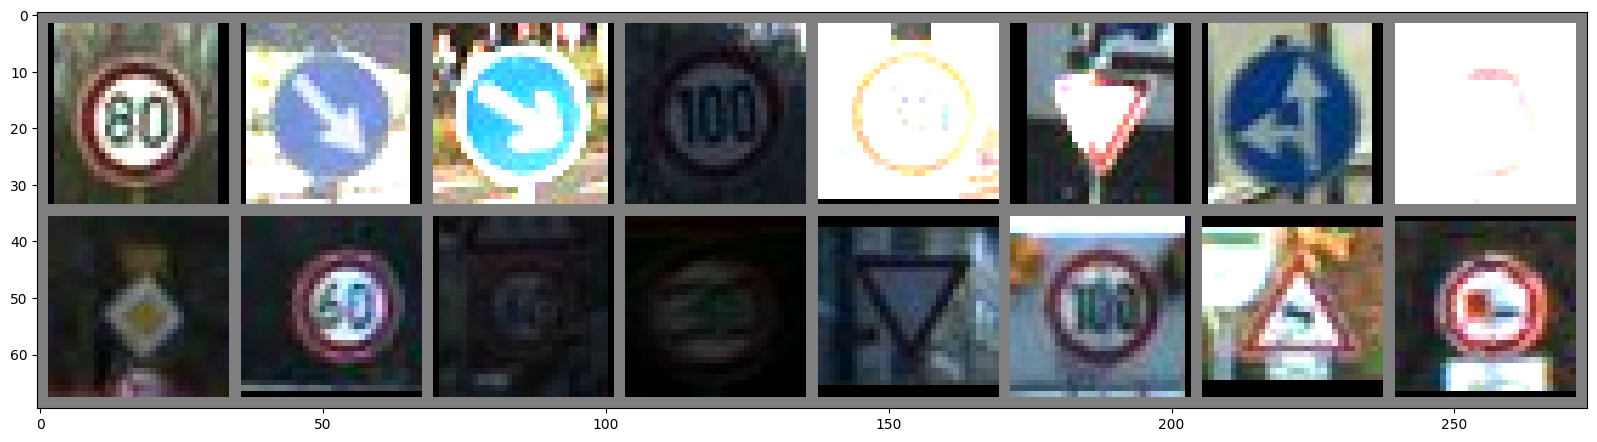

In [90]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 10))

# get some random training images
images, labels = next(iter(train_loader))


def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
images, labels = next(iter(train_loader))

# show images
imshow(torchvision.utils.make_grid(images))

# print(" ".join(f"{idx_to_class[labels[j]]}" for j in range(batch_size)))

# Encoder


In [91]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc_var = nn.Linear(hidden_dim, latent_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

        self.training = True

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.LeakyReLU(self.fc_1(x))
        x = self.LeakyReLU(self.fc_2(x))
        mean = self.fc_mean(x)
        log_var = self.fc_var(x)  # encoder produces mean and log of variance
        #             (i.e., parateters of simple tractable normal distribution "q"

        return mean, log_var

# Decoder


In [92]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc_1 = nn.Linear(latent_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc_3 = nn.Linear(hidden_dim, output_dim)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def forward(self, x):
        h = self.LeakyReLU(self.fc_1(x))
        h = self.LeakyReLU(self.fc_2(h))

        x_hat = torch.sigmoid(self.fc_3(h))
        x_hat = x_hat.view([-1, 1, 28, 28])
        return x_hat

# VAE


In [93]:
class VAE(nn.Module):
    def __init__(self, x_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(
            input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim
        )
        self.decoder = Decoder(
            latent_dim=latent_dim, hidden_dim=hidden_dim, output_dim=x_dim
        )

    def reparameterization(self, mean, var):
        eps = torch.randn_like(mean)
        z = eps * var + mean
        return z

    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterization(
            mean, torch.exp(0.5 * log_var)
        )  # takes exponential function (log var -> var)
        x_hat = self.decoder(z)
        return x_hat, mean, log_var

# VAE training

In [94]:
vae = VAE(latent_dim=16, hidden_dim=256, x_dim=784).to(device)

In [95]:
def vae_loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.mse_loss(x_hat, x, reduction="sum")
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [96]:
optimizer = optim.Adam(vae.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.99)

In [97]:
num_epochs = 2
for n in range(num_epochs):
    losses_epoch = []
    for x, _ in iter(train_loader):
        x = x.to(device)
        out, means, log_var = vae(x)
        loss = vae_loss_function(x, out, means, log_var)
        losses_epoch.append(loss.item())
        loss.backward()  # backward pass (compute parameter updates)
        optimizer.step()  # make the updates for each parameter
        optimizer.zero_grad()
    L1_list = []
    #     if n % 10 == 0:
    for x, _ in iter(val_loader):
        x = x.to(device)
        out, _, _ = vae(x)
        L1_list.append(torch.mean(torch.abs(out - x)).item())
    print(
        f"Epoch {n} loss {np.mean(np.array(losses_epoch))}, test L1 = {np.mean(L1_list)}"
    )
    scheduler.step()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x3072 and 784x256)

In [ ]:
generate_images(vae, 16, device)

# Evaluator

In [ ]:
class Evaluator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Evaluator, self).__init__()

        self.fc_1 = nn.Linear(input_dim, hidden_dim)
        self.fc_2 = nn.Linear(hidden_dim, 50)
        self.fc_out = nn.Linear(50, 10)

        self.LeakyReLU = nn.LeakyReLU(0.2)

    def get_features(self, x):
        x = torch.flatten(x, 1)
        x = self.LeakyReLU(self.fc_1(x))
        x = self.LeakyReLU(self.fc_2(x))
        return x

    def forward(self, x):
        x = self.get_features(x)
        x = self.fc_out(x)
        return x


evaluator = Evaluator(28 * 28, 256).to(device)

# Fretchet distance

In [ ]:
######### Frechet Inception distance based on implementation from https://github.com/mseitzer/pytorch-fid

import numpy as np
from scipy import linalg


def calculate_frechet_distance(distribution_1, distribution_2, eps=1e-6):
    mu1 = np.mean(distribution_1, axis=0)
    sigma1 = np.cov(distribution_1, rowvar=False)

    mu2 = np.mean(distribution_2, axis=0)
    sigma2 = np.cov(distribution_2, rowvar=False)

    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    Stable version by Dougal J. Sutherland.
    Params:
    -- mu1   : Numpy array containing the activations of a layer of the
               inception net (like returned by the function 'get_predictions')
               for generated samples.
    -- mu2   : The sample mean over activations, precalculated on an
               representative data set.
    -- sigma1: The covariance matrix over activations for generated samples.
    -- sigma2: The covariance matrix over activations, precalculated on an
               representative data set.
    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert (
        mu1.shape == mu2.shape
    ), "Training and test mean vectors have different lengths"
    assert (
        sigma1.shape == sigma2.shape
    ), "Training and test covariances have different dimensions"

    diff = mu1 - mu2

    # Product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = (
            "fid calculation produces singular product; "
            "adding %s to diagonal of cov estimates"
        ) % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError("Imaginary component {}".format(m))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean